# Bridge Condition Analysis


## Table of Contents 

### Part 1: Data Preparation
1. **Task 1**: Load the data, extract relevant columns for derivation of variables.
2. **Task 2**: Reduce the number of categories of materials and designs.
3. **Task 3**: Compute the label variable, representing the current condition of the bridge.
4. **Task 4**: Review the distributions of the continuous predictor variables.
5. **Task 5**: Final filtering of the dataframe.

---

### Part 2: Exploratory Analysis
1. **Task 1**: Analyse relationships between predictor variables and the target label
   - **A)** Continuous Predictors vs. Current Condition
   - **B)** Categorical Predictors vs. Current Condition
   
   
   

2. **Task 2**: Analyse relationships among the predictor variables
   - **A)** Relationships among Continuous Predictors
   - **B)** Relationships among Categorical Predictors
   - **C)** Continuous Predictors vs. Categorical Predictors

---

### Part 3: Regression Modelling
1. **Task 1**: Construct a Linear Regression Model and Analyse Key Metrics
2. **Task 2**: Distribution of Residuals
3. **Task 3**: Regression Coefficient Analysis
4. **Task 4**: Interpreting Each Predictor’s Influence
5. **Task 5**: Conclusions and Suggestions for Further Analysis


### ***Part 1: Data Preparation***


The primary goals of Part 1 are to prepare and clean the dataset so it’s suitable for exploratory and regression analysis, ensuring that all relevant variables are accurately represented and meaningful.

#### Part 1 of the report will be split into the following tasks:

Task 1: Load the data, extract relevant columns from the data for derivation of variables.

Task 2: Reduce the number of categories of materials and designs.

Task 3: Compute the label variable, representing the current condition of the bridge.

Task 4: Review the distributions of the continuous predictor variables.

Task 5: Final filtering of the dataframe.


#### Task 1: Load the data, extract relevant columns from the data for derivation of variables


Loading relevant python libraries

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

The code cell below creates a type map for efficient data type management. Specifying data types and establishing a well-structured dataframe is crucial for the derivation and analysis of variables in this report.

In [197]:
# The code below declares a catageorical type with categories in a specified order
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges.head(3)  

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150


The next cells below handle transformation of data and initial derivation of new variables. The goal is to create a dataframe that includes the 5 relevant predictor variables: Age, Average Use, Percent Trucks, Material, Design and one target (current condition) label, which is derived from the combination of Deck_rating, Superstr_rating and Substr_rating. Current Condition variable will be derived in Task 3. These 6 variables will be the core of our model in the report.

In [198]:
# Filter the dataframe to only include relevant variables to the analysis. Historic column is kept in order to exclude old bridges
relevant_columns = ['Year', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 
                    'Deck_rating', 'Superstr_rating', 'Substr_rating', 'Historic']
bridges_filtered = bridges[relevant_columns]

# Keep only rows that do NOT match the historic variable with a value of 'Possible', to exclude historic bridges
bridges_filtered = bridges_filtered[~(bridges_filtered['Historic'] == 'Possible')]

# Remove unused categories from the 'Historic' column to fully exclude 'Possible' as a category
bridges_filtered['Historic'] = bridges_filtered['Historic'].cat.remove_unused_categories()

# Derive the age of the bridge with a simple subtraction of a given bridge's construction year from the current year, 2024
current_year = 2024
bridges_filtered['Age'] = current_year - bridges_filtered['Year']

#### Task 2: Reduce the number of categories of materials and designs

Reducing the number of categories of material and design can help with reducing noise and avoiding overfitting. By combining less frequent categories, the analysis will focus on more relevant and impactful categories. 
Firstly check the frequencies of the existent categories for Material:

In [199]:
# counts of each category in 'Material' to identify less frequent ones
material_counts = bridges_filtered['Material'].value_counts()
print(material_counts)

Concrete    16240
Steel        3748
Timber        353
Other          40
Masonry         6
Name: Material, dtype: int64


Perform the same analysis for Design

In [200]:
design_counts = bridges_filtered['Design'].value_counts()
print(design_counts)

Beam          17954
Slab           1120
Other          1002
Truss           133
Arch            119
Frame            42
Movable          12
Suspension        5
Name: Design, dtype: int64


Observing the category frequencies for the Material variable, I made a decision to merge Timber, Other and Masonry into one category 'Other Materials'. Similarly, for the Design variable, I am merging Other, Truss, Arch, Frame, Movable and Suspension into a combined 'Other Design' category. The cell below handles that:

In [201]:
# Merge less frequent categories in 'Material' column
bridges_filtered['Material'] = bridges_filtered['Material'].replace(
    {'Timber': 'Other Materials', 'Other': 'Other Materials', 'Masonry': 'Other Materials'}
)

bridges_filtered['Design'] = bridges_filtered['Design'].replace(
    {'Other': 'Other Design', 'Truss': 'Other Design', 'Arch': 'Other Design', 'Frame': 'Other Design', 
     'Movable': 'Other Design', 'Suspension': 'Other Design'}
)

# Verify the updated categories and counts
print(bridges_filtered['Material'].value_counts())

print(bridges_filtered['Design'].value_counts())


Concrete           16240
Steel               3748
Other Materials      399
Name: Material, dtype: int64
Beam            17954
Other Design     1313
Slab             1120
Name: Design, dtype: int64


In [202]:
bridges_filtered.head()

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Historic,Age
Structure_id,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,Not historic,19
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,Not historic,19
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,Not historic,12
000021525-00012,1950,80,0.0,Other Materials,Beam,Good,Good,Poor,Not historic,74
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,Not historic,20


#### Task 3: Compute the label variable, representing the current condition of the bridge

The next step is to compute current condition, which is derived from the combination of the three main
condition variables Deck_rating, Superstr_rating and Substr_rating, which correspond to deck, superstructure and substructure condition ratings respectively. Each of the 3 rating categories ranges between 0 and 9, and the current condition is the sum of these categories.

In [203]:
# Define the mapping to convert categories into numerical values
rating_mapping = {
    'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4, 
    'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9, 'NA': None
}

# new numerical column for Deck_rating
bridges_filtered['Deck_rating_numeric'] = bridges_filtered['Deck_rating'].map(rating_mapping)
# new numerical column for Superstr_rating
bridges_filtered['Superstr_rating_numeric'] = bridges_filtered['Superstr_rating'].map(rating_mapping)
# new numerical column for Substr_rating
bridges_filtered['Substr_rating_numeric'] = bridges_filtered['Substr_rating'].map(rating_mapping)

# column for the current condition label
bridges_filtered['Current_Condition'] = (
    bridges_filtered['Deck_rating_numeric'] + 
    bridges_filtered['Superstr_rating_numeric'] + 
    bridges_filtered['Substr_rating_numeric']
)

The next step of Data Preparation is to get rid of all the unnecessary columns that have been created for the derivation of relevant predictor variables. The filtered bridges_filtered dataframe will consist of 5 predictor variable columns (Age, Average Use, Percent Trucks, Material and Design) and one label variable column, Current Condition. 

In [204]:
# Select only the relevant columns
bridges_filtered = bridges_filtered[['Age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Current_Condition']]

# Rename columns to match the specified names
bridges_filtered.rename(columns={
    'AverageDaily': 'Average Use',
    'Trucks_percent': 'Percent Trucks',
    'Material': 'Material',
    'Design': 'Design', 'Current_Condition': 'Current Condition'
}, inplace=True)

You can see an excerpt of the dataframe, containing all relevant predictors and the label

In [205]:
bridges_filtered.head()

,Age,Average Use,Percent Trucks,Material,Design,Current Condition
Structure_id,,,,,,
000021521-00101,19,1,0.0,Concrete,Slab,23.0
000021521-00181,19,1,0.0,Concrete,Slab,22.0
000021521-TMP20,12,100,0.0,Concrete,Beam,24.0
000021525-00012,74,80,0.0,Other Materials,Beam,18.0
000021580-00092,20,150,4.0,Concrete,Beam,23.0


#### Task 4: Review the distributions of the continuous predictor variables

3 of the predictor variables are continuous (Age, Average Use, Percent Trucks). It is vital to analyse the distributions of these variables, and review outliers. The cell below produces central tendencies, box plots and histograms for each of the continuous variables

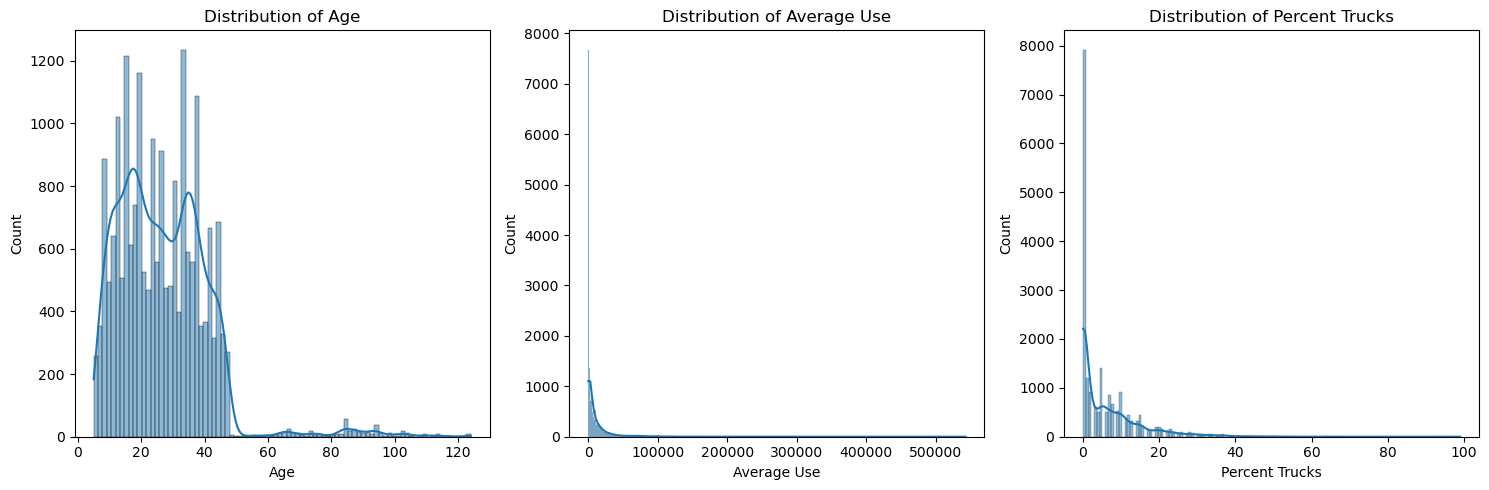

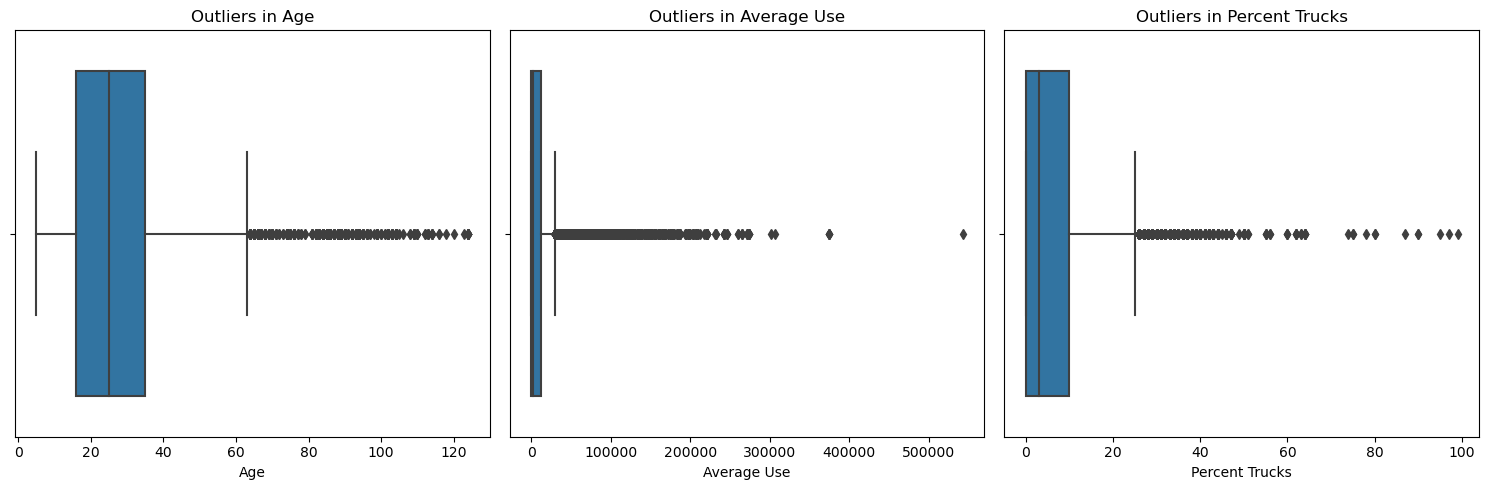

                Age    Average Use  Percent Trucks
count  20387.000000   20387.000000    20387.000000
mean      26.735714   11766.140236        6.257713
std       14.435617   25520.414401        8.608242
min        5.000000       0.000000        0.000000
25%       16.000000     180.000000        0.000000
50%       25.000000    2900.000000        3.000000
75%       35.000000   12000.000000       10.000000
max      124.000000  543000.000000       99.000000


In [206]:
#Reviewing distributions of continuous variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(bridges_filtered['Age'], kde=True)
plt.title('Distribution of Age')

plt.subplot(1, 3, 2)
sns.histplot(bridges_filtered['Average Use'], kde=True)
plt.title('Distribution of Average Use')

plt.subplot(1, 3, 3)
sns.histplot(bridges_filtered['Percent Trucks'], kde=True)
plt.title('Distribution of Percent Trucks')

plt.tight_layout()
plt.show()

# Check for outliers in continuous variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=bridges_filtered['Age'])
plt.title('Outliers in Age')

plt.subplot(1, 3, 2)
sns.boxplot(x=bridges_filtered['Average Use'])
plt.title('Outliers in Average Use')

plt.subplot(1, 3, 3)
sns.boxplot(x=bridges_filtered['Percent Trucks'])
plt.title('Outliers in Percent Trucks')

plt.tight_layout()
plt.show()

# Step 3: Summary statistics for continuous variables
print(bridges_filtered[['Age', 'Average Use', 'Percent Trucks']].describe())


#### Age
* The Age distribution is right-skewed, with most bridges clustered around lower ages and a long tail extending to the right. This indicates that most bridges in the dataset are relatively new, with fewer older bridges.
* There are outliers on the high end, with some bridges as old as 124 years old.
* Older bridges could be of particular interest, as they may have unique deterioration patterns due to prolonged fatigue stress. Removing them might eliminate useful information about how age impacts condition. 

#### Average Use
* Average Use is highly skewed to the right, with most values clustered near zero and a long tail extending towards very high usage.
* Bridges with very high usage likely represent critical infrastructure for certain urban areas. Therefore it is important to take them into account for our analysis.

#### Percent Trucks
* This variable is also right-skewed, with most values concentrated at the lower end
* Bridges with high truck percentages are also high-stress structures. Since truck traffic can have a significant impact on structural wear and tear, these data points could be important for predicting condition.


Therefore I believe that the outliers represent plausible values, rather than data errors. Given the context and scope of this report, it is important not to remove any outliers, as they represent unique but potentially critical cases.


#### Task 5: Final filtering of the dataframe containing the variables

Final step of data preparation is to check for missing values in our filtered dataframe.

In [207]:
# Check for NaNs in each column
print(bridges_filtered.isnull().sum())

Age                  0
Average Use          0
Percent Trucks       0
Material             0
Design               0
Current Condition    4
dtype: int64


Current Condition column contains 4 NaN values. Since there are only 4 entries, I am dropping these data points from the dataframe

In [208]:
# Drop rows with NaN values in the 'Current Condition' column
bridges_filtered = bridges_filtered.dropna(subset=['Current Condition'])

# Verify that there are no more NaNs in 'Current Condition'
print(bridges_filtered.isnull().sum())


Age                  0
Average Use          0
Percent Trucks       0
Material             0
Design               0
Current Condition    0
dtype: int64


Below you can see our final bridges_filtered data frame that will be used in parts 2 & 3:

In [209]:
bridges_filtered.head()

,Age,Average Use,Percent Trucks,Material,Design,Current Condition
Structure_id,,,,,,
000021521-00101,19,1,0.0,Concrete,Slab,23.0
000021521-00181,19,1,0.0,Concrete,Slab,22.0
000021521-TMP20,12,100,0.0,Concrete,Beam,24.0
000021525-00012,74,80,0.0,Other Materials,Beam,18.0
000021580-00092,20,150,4.0,Concrete,Beam,23.0


### ***Part 2: Exploratory Analysis***

The goal of this part of the report is to explore the relationship between all of the variables in our dataframe. The approach will vary, since some predictors are of continuous nature whilst others are of categorical nature. Part 2 of the report will be split into the following tasks.

Task 1: Analyse relationships between predictor variables and the target label
* A) Continuous Predictors vs Current Condition
* B) Categorical Predictors vs Current Condition

Task 2: Analyse relationships among the predictor variables
* A) Relationships among Continuous Predictors
* B) Relationships among Categorical Predictors
* C) Continuous Predictors vs Categorical Predictors


<div style="text-align: center;"><strong>Table 1: Variable Types and Descriptions</strong></div>

| Variable          | Type of Variable | Description                                                                           |
|:------------------|:-----------------|:--------------------------------------------------------------------------------------|
| Material          | Categorical      | The values are categories: they can neither be added nor ordered. Example: concrete, steel, timber |
| Design            | Categorical      | The values are categories: different bridge designs. Example: slab, beam              |
| Age               | Continuous       | The values are numbers from an infinite set of possible values. Represents bridge age in years |
| Current Condition | Continuous       | The values are numerical, representing an aggregated condition score for the bridge    |
| Average Use       | Continuous       | The values are numbers representing the average daily use of the bridge               |
| Percent Trucks    | Continuous       | The values are numbers from an infinite set, representing the percentage of trucks using the bridge |


#### Task 1: Analyse relationships with the target variable
* Goal: See if there is a relationship (linear or non-linear) between each continuous and categorical predictor and current condition
* For continious predictors like Age, Average Use and Percent Trucks scatter plots and correlation coefficients are used to check for linearity of the relationship
* For categorical predictors like Material and Design, box plots will be used to compare the distribution of Current Condition across different categories within each distinct predictor

This would demonstrate if certain materials or designs tend to correlate with better or worse conditions

#### A) Continuous Predictors: Age, Average Use, Percent Trucks
* Analysing the relationship between our continuous predictors and the current condition of a given bridge
* Correlation coefficients and scatter plots will be used to assess if there is a presence of a linear or non-liner relationship with Current Condition label.


The cell below produces a correlation matrix giving an insight into the relationship of current bridge condition with each continuous predictor:

In [210]:
# Select the relevant continuous columns
continuous_cols = ['Current Condition', 'Age', 'Average Use', 'Percent Trucks']
correlation_matrix = bridges_filtered[continuous_cols].corr()

# Displaying the correlation of Current Condition with each continuous predictor
print(correlation_matrix['Current Condition'])


Current Condition    1.000000
Age                 -0.547747
Average Use          0.052935
Percent Trucks       0.082002
Name: Current Condition, dtype: float64


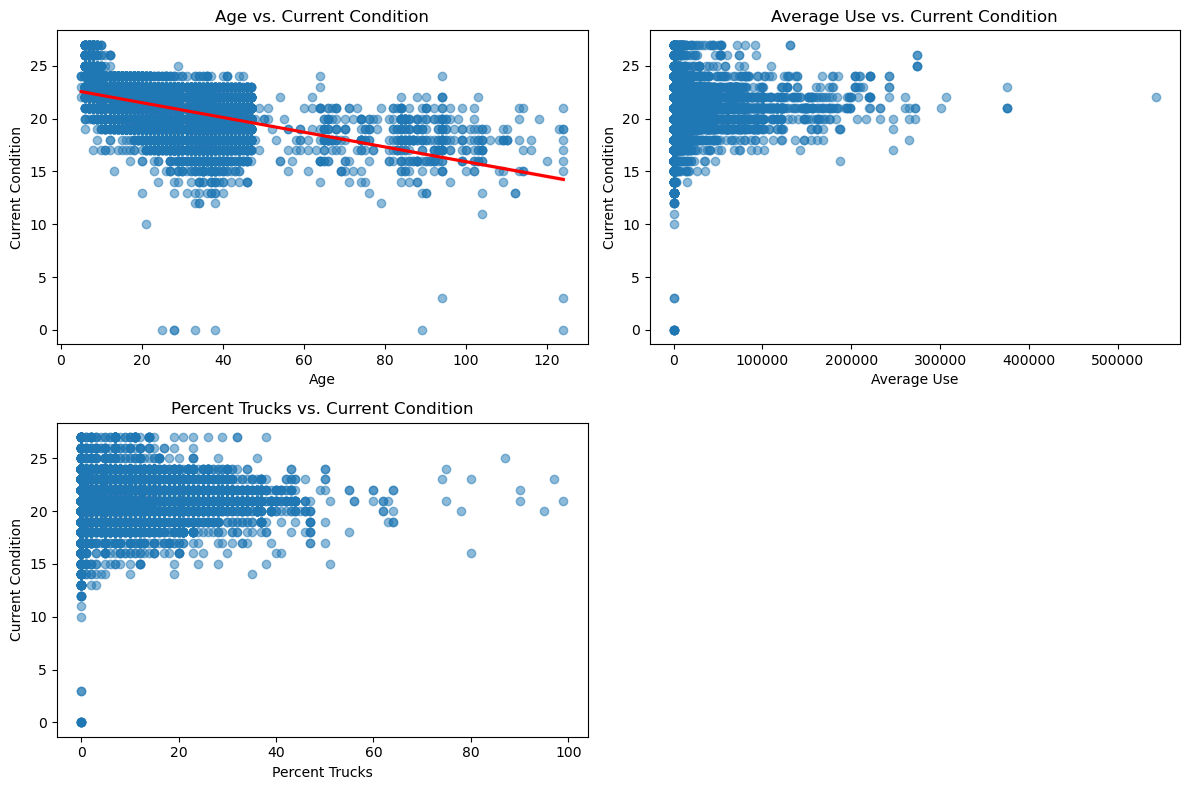

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2x2 grid of subplots, with the last subplot empty
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.delaxes(axs[1, 1])  # Remove the unused subplot (bottom right)

# Scatter plot with line of best fit for Age vs. Current Condition
sns.regplot(x='Age', y='Current Condition', data=bridges_filtered, ax=axs[0, 0], scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Current Condition')
axs[0, 0].set_title('Age vs. Current Condition')

# Scatter plot for Average Use vs Current Condition
axs[0, 1].scatter(bridges_filtered['Average Use'], bridges_filtered['Current Condition'], alpha=0.5)
axs[0, 1].set_xlabel('Average Use')
axs[0, 1].set_ylabel('Current Condition')
axs[0, 1].set_title('Average Use vs. Current Condition')

# Scatter plot for Percent Trucks vs. Current Condition
axs[1, 0].scatter(bridges_filtered['Percent Trucks'], bridges_filtered['Current Condition'], alpha=0.5)
axs[1, 0].set_xlabel('Percent Trucks')
axs[1, 0].set_ylabel('Current Condition')
axs[1, 0].set_title('Percent Trucks vs. Current Condition')

# Adjust layout to avoid overlapping labels and titles
plt.tight_layout()
plt.show()


#### Age vs. Current Condition:

* The plot shows a negative trend, which aligns with the moderate negative correlation of -0.547747.
* A line of best fit was used to make the relationship more visually apparent
* As Age increases, Current Condition tends to decrease, indicating that older bridges are generally in poorer condition.
* The data points are somewhat dispersed but still show a downward trend, which matches our expectations.

#### Average Use vs. Current Condition:

* There appears to be no clear trend in the scatter plot, which corresponds with the very low correlation (0.052935).
* The points are spread out without a discernible upward or downward pattern, confirming that Average Use may have little influence on Current Condition.

#### Percent Trucks vs. Current Condition:

* Similarly, there’s no strong visible trend in this plot, which matches the weak positive correlation (0.082002).
* While there’s some slight clustering of points at lower Percent Trucks values, the points are largely scattered, showing minimal association.

Overall, these scatter plots visually suggest the following from the correlation values:

* Age has the most significant influence on Current Condition.
* Average Use and Percent Trucks show very weak or negligible linear relationships with Current Condition.

#### B) Categorigal Predictors: Material, Design
* Analysing the relationship between our categorical predictors and the current condition of a given bridge.
* The distribution of Current Condition scores across distinct categories of materials and design can be visualised with box plots and violin plots.

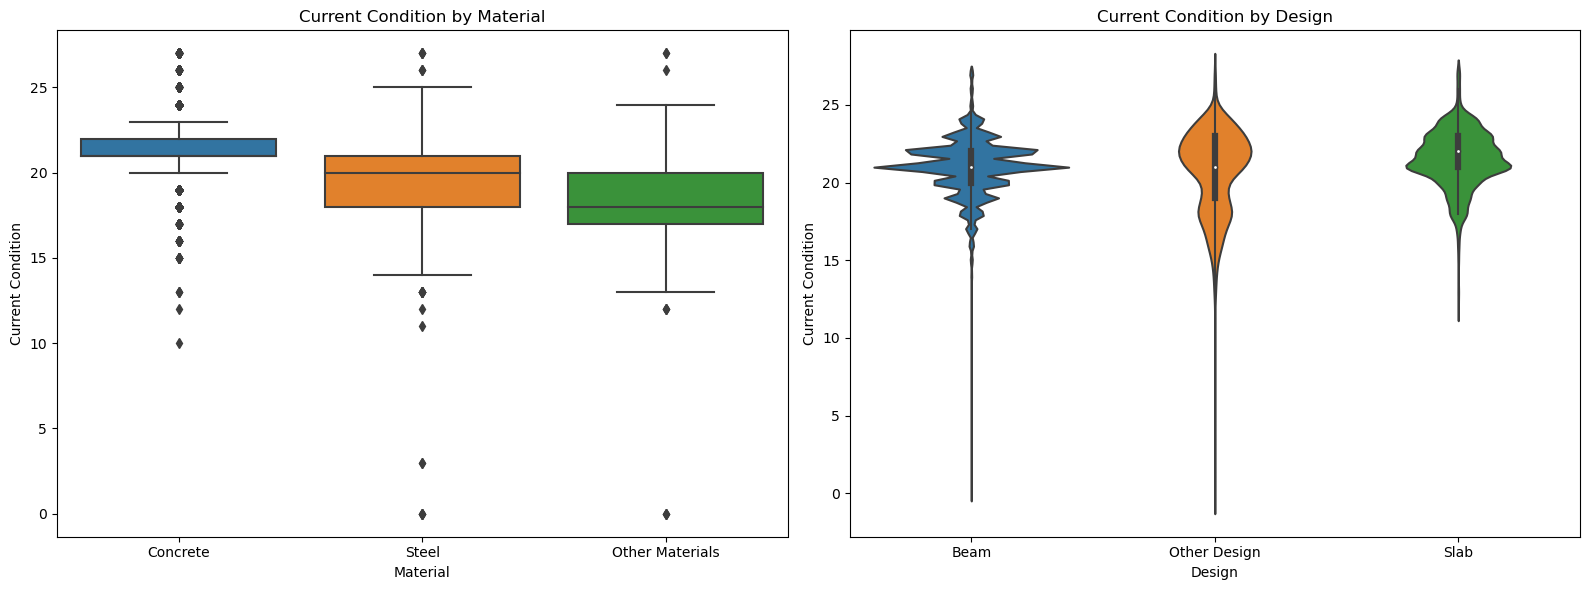

Statistics for Current Condition by Design:
                   Mean  Median    Q1    Q3  IQR   Min   Max    StdDev
Design                                                                
Beam          21.026846    21.0  20.0  22.0  2.0   0.0  27.0  1.748886
Other Design  20.702827    21.0  19.0  23.0  4.0   0.0  27.0  2.765753
Slab          21.520536    22.0  21.0  23.0  2.0  12.0  27.0  1.815318

Statistics for Current Condition by Material:
                      Mean  Median    Q1    Q3  IQR   Min   Max    StdDev
Material                                                                 
Concrete         21.445095    21.0  21.0  22.0  1.0  10.0  27.0  1.495997
Steel            19.537497    20.0  18.0  21.0  3.0   0.0  27.0  2.022529
Other Materials  18.315789    18.0  17.0  20.0  3.0   0.0  27.0  2.866463


In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for material vs Current Condition
sns.boxplot(x='Material', y='Current Condition', data=bridges_filtered, ax=axs[0])
axs[0].set_title('Current Condition by Material')

# Violin plot for Design vs current Condition
sns.violinplot(x='Design', y='Current Condition', data=bridges_filtered, ax=axs[1])
axs[1].set_title('Current Condition by Design')

plt.tight_layout()
plt.show()

# Calculate statistics for Current Condition grouped by Material
material_stats = bridges_filtered.groupby('Material')['Current Condition'].agg(
    Mean='mean',
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
    Min='min',
    Max='max',
    StdDev='std'
)

# Calculate statistics for Current Condition grouped by Design
design_stats = bridges_filtered.groupby('Design')['Current Condition'].agg(
    Mean='mean',
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
    Min='min',
    Max='max',
    StdDev='std'
)

print("Statistics for Current Condition by Design:")
print(design_stats)
print()
print("Statistics for Current Condition by Material:")
print(material_stats)

##### Box Plot (Material vs. Current Condition)
* Concrete: This category has a higher median and a relatively narrow interquartile range (IQR), suggesting that concrete bridges tend to have consistently high condition ratings.
* Steel: Steel bridges show a slightly lower median with a wider spread, indicating more variability in condition ratings. The presence of lower outliers suggests that some steel bridges may be in poorer condition.
* Other Materials: This group has the lowest median and the widest spread, with significant variability and more lower outliers. This may suggest that bridges made from other materials are generally in worse condition.

#### Violin Plot (Design vs. Current Condition)
* Beam: The distribution is relatively narrow and centered around higher condition scores, indicating consistency in the condition of beam bridges.
* Other Design: This category has a broader distribution, with more variation in the condition scores. The distribution suggests that certain "Other Design" bridges may be in both very high and very low conditions.
* Slab: Slab bridges show a high median condition, similar to beam bridges, with a narrow distribution, indicating that slab bridges are generally in good condition.

#### Task 2: Analyse relationships among predictor variables
* Goal: See if two or more predictor variables are highly correlated. Multicollinearity may cause overlapping and redundant information about the target variable
* Multicollinearity occurs when two or more predictor variables are highly correlated. This can be problematic in regression analysis because it makes it hard to separate the individual effect of each predictor on the condition of the bridge.
* Identifying multicollinearity is useful for selecting which predictors to include or exclude in the model.




#### A) Relationship among Continuous Predictors

* Check for multicollinearity among Age, Average Use, and Percent Trucks.
* The correlation matrix below visualises continuous predictors to check for any strong relationships


                     Age  Average Use  Percent Trucks
Age             1.000000    -0.041561       -0.000299
Average Use    -0.041561     1.000000        0.081251
Percent Trucks -0.000299     0.081251        1.000000


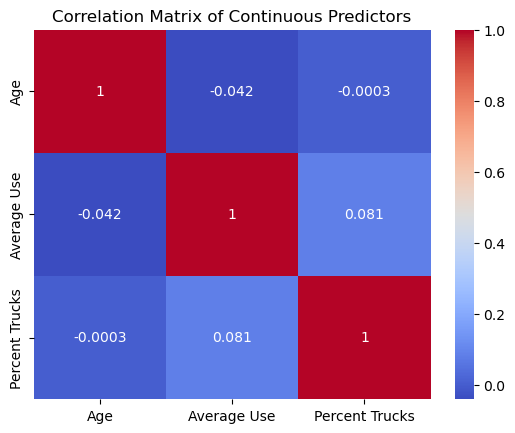

In [213]:
# Correlation matrix for continuous predictors
# matrix provides pairwise correlation coefficients between each pair of continuous predictors
continuous_predictors = ['Age', 'Average Use', 'Percent Trucks']
predictor_corr_matrix = bridges_filtered[continuous_predictors].corr()
print(predictor_corr_matrix)

# visualising with a heatmap
sns.heatmap(predictor_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Continuous Predictors')
plt.show()


As seen above, none of the continuous predictors are signifantly correlated to any of the other predictors. This concludes that multicollinearity is **not** an issue in our case.

#### B) Relationship among Categorical Predictors
* Checking for an association between Material and Design.
* To do that I am using a chi-squared test of independence. Null Hypothesis (H0) assumes that there is no association between the two predictors. The magnitude of the chi-square value represents the magnitude of the difference between the observed and expected counts. In other words, a high value would suggest a strong association
* The contingency table has rows representing categories of the bridge material and columns representing categories of bridge design


In [214]:
from scipy.stats import chi2_contingency

# Crosstab for Material and Design
material_design_crosstab = pd.crosstab(bridges_filtered['Material'], bridges_filtered['Design'])
print(material_design_crosstab)

# Chi-square test
chi2, p, dof, ex = chi2_contingency(material_design_crosstab)
print(f"Chi-square test result: chi2 = {chi2}, p-value = {p}")


Design            Beam  Other Design  Slab
Material                                  
Concrete         14286           831  1120
Steel             3316           431     0
Other Materials    352            47     0
Chi-square test result: chi2 = 497.5067159540498, p-value = 2.318999269195753e-106


Interpretation of the results: 
* The chi-square test result has a relatively high value, indicating that a large difference between the observed and expeced frequencies in the contingency table is present.
* Tiny p-value (below 0.05) means that the null hypothesis is rejected and there is a statistically significant associatiion between the two categorical predictors.
* This makes sense, since some certain bridge designs may traditionally involve certain materials, such as concrete being often used with a beam design.

#### C) Relationship between continuous and categorical predictors
* Checking for patterns between continuous predictors and categorical predictors.
* For this analysis we are once again employing box plots and violing plots.

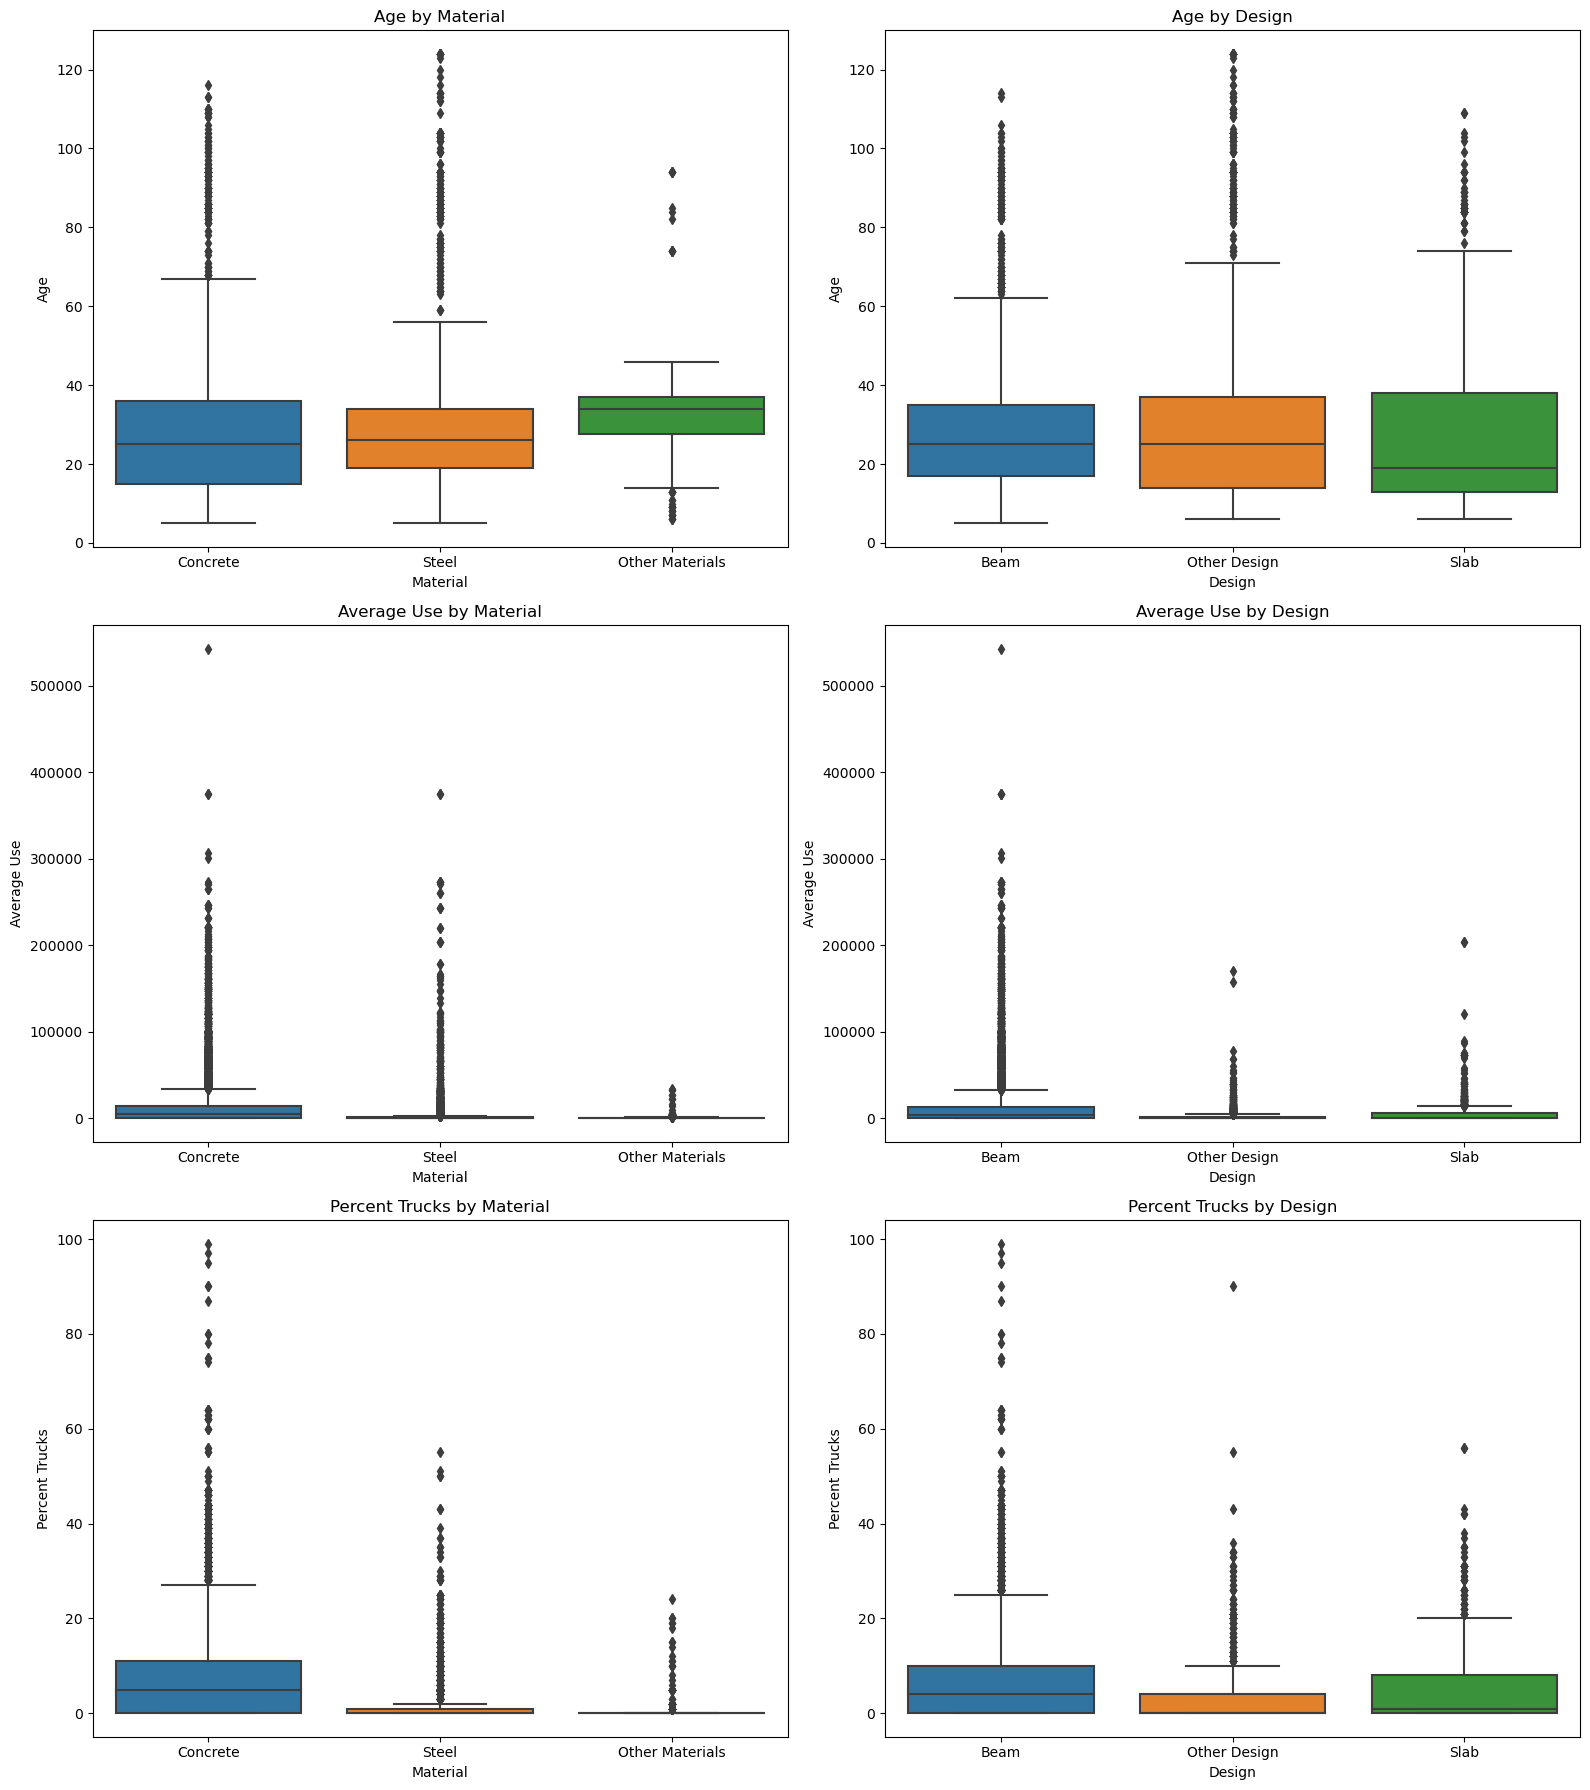

In [215]:
# Set the figure size for consistency
plt.figure(figsize=(16, 18))

# Age distribution by Material
plt.subplot(3, 2, 1)
sns.boxplot(x='Material', y='Age', data=bridges_filtered)
plt.title('Age by Material')

# Age distribution by Design
plt.subplot(3, 2, 2)
sns.boxplot(x='Design', y='Age', data=bridges_filtered)
plt.title('Age by Design')

# Average Use distribution by Material
plt.subplot(3, 2, 3)
sns.boxplot(x='Material', y='Average Use', data=bridges_filtered)
plt.title('Average Use by Material')

# Average Use distribution by Design
plt.subplot(3, 2, 4)
sns.boxplot(x='Design', y='Average Use', data=bridges_filtered)
plt.title('Average Use by Design')

# Percent Trucks distribution by Material
plt.subplot(3, 2, 5)
sns.boxplot(x='Material', y='Percent Trucks', data=bridges_filtered)
plt.title('Percent Trucks by Material')

# Percent Trucks distribution by Design
plt.subplot(3, 2, 6)
sns.boxplot(x='Design', y='Percent Trucks', data=bridges_filtered)
plt.title('Percent Trucks by Design')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##### Age by Material and Design
Material:
* Concrete bridges tend to have a broader age range, with the median age around the middle of the range, indicating that concrete is used in both older and newer bridges.
* Steel bridges have a lower median age than concrete, and the age distribution shows a narrower range, suggesting that steel might be more commonly used in relatively newer bridges.
* Other Materials have a notably lower age range and a tight distribution, indicating that bridges made of alternative materials are typically newer.

Design:
* Beam and Slab designs have a similar age distribution, but slab bridges tend to be slightly younger
* Other Design has a wider age distribution, possibly meaning that it may include a mix of older and newer bridge types

Conclusion:
* Concrete is widely used across all ages, including older bridges, while steel and other materials appear in relatively newer structures.

##### Percent Trucks by Material and Design
Material:
* Concrete bridges have a wider distribution of truck percentages, with many outliers at higher percentages, indicating that concrete bridges are more frequently used for heavy-duty traffic.
* Steel and Other Materials have a much narrower range, with a median close to zero, indicating that bridges made from these materials are less likely to have a high percentage of truck traffic

Design: 
* The Beam design has the widest spread in terms of truck percentages, with a significant number of outliers, suggesting it’s more commonly used for bridges that bear heavy truck traffic.
* Other Design and Slab both have a narrower distribution, with most values clustered near the lower range.

Conclusion: 
* Concrete bridges and beam designs are more commonly associated with higher truck percentages, indicating that they might be preferred for locations where heavy vehicle traffic is common.

##### Average Use by Material and Design
Material: 
* Concrete shows a wider distribution for average age compared to other materials, with high outliers suggesting concrete is used in areas of both high and low traffic volumes.
* Steel and Other Materials have lower median values for average use, with minimal outliers, suggesting these materials are typically used in areas with lower traffic volumes.

Design: 
* Beam has a wide range of average use, again with outliers suggesting it is often used in high-traffic areas.
* Other Design and Slab designs tend to have lower average use, suggesting they may be used in less trafficked locations.

Conclusion:
* Concrete material and beam design are associated with higher average traffic, while steel, other materials, and designs like Slab and Other Design are generally associated with lighter traffic.

### Part 3: Regression Modelling
This part of the report will construct a linear regression model to look at the effect of five predictors on the condition of the bridge. Linear regression quantifies the relationship between predictors and the target. This model will help determine how much each predictor contributes to the bridge's condition. By the end of this section the following two questions will be answered:
1) Can the proposed variables predict the condition of the bridge accurately, and to what extent?
2) Which of the proposed variables has more influence on the condition of the bridge

This section of the report will be split into the following tasks:

Task 1: Construct a Linear Regression Model and Analyse Key Metrics

Task 2: Distribution of Residuals

Task 3: Regression Coefficient Analysis

Task 4: Interpreting Each Predictor’s Influence

Task 5: Conclusions and Suggestions for Further Analysis

#### Task 1: Construct a Linear Regression Model and Analyse Key Metrics

As we've discussed earlier, two of our predictors are categorical variables. Therefore it is vital to transform them into a numerical format for the regression model. One-hot encoding method is used for this purpose, by representing each category as a binary variable (1 or 0). That way, the method enables us to include categorical data in the numerical model, whilst retaining valuable category information.

In simple linear regression with one predictor, the line of best fit minimises the sum of squared residuals between the predicted values of the bridge condition and the actual value. Since we're concerned with multivariate linear regression, the 'line' of best fit becomes a hyperplane in multiple dimensions.

The cell below plots our 5 predictors on the x-axis and the current condition label on the y-axis. A regression model is fit to the data, computing regression coefficients that relate each predictor to current condition. 

One of the metrics we use to assess the quality of our model’s fit is called R² (R-squared), or the coefficient of determination. R² is a measure that represents the proportion of variability in the bridge’s condition that is explained by the predictors in our model.

* An R² value of 1 means that the model explains 100% of the variability in bridge condition, meaning the predictions perfectly match the actual data points.
* An R² value of 0 means that the predictors have no explanatory power, and the model does no better than a simple average in predicting bridge condition.


In other words, the closer the R² value is to 1, the better our model explains the condition of bridges based on the predictors we’ve included

Another key metric is the Root Mean Squared Error (RMSE). It is a commonly used metric for evaluating the accuracy of a regression model. It represents the average magnitude of error in the model’s predictions, expressed in the same units as the target variable—in this case, Current Condition of bridges.

The metrics are computed and evaluated below:

In [216]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Prepare the predictors (X) and target variable (y)
X = bridges_filtered[['Age', 'Average Use', 'Percent Trucks', 'Material', 'Design']]
y = bridges_filtered['Current Condition']

# Step 2: One-hot encode categorical variables
X = pd.get_dummies(X, columns=['Material', 'Design'], drop_first=True)

# Step 3: Initialize and fit the linear regression model on the entire dataset
model = LinearRegression()
model.fit(X, y)

# Step 4: Make predictions on the same dataset (since we're analyzing the entire data)
y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))


# Step 5: Evaluate the model (R² score on the full dataset)
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


R² Score: 0.4612
RMSE: 1.3506


An R² score of 46.12% means that the 46.12% of the variability within the Current Condition variable can be explained by the 5 predictors. Effectively this means that in its current form, the model has moderate predictive power. 

An RMSE of 1.35 means that, on average, the model’s predictions of the bridge condition deviate from the actual condition by about 1.35 points



In [217]:
min_condition = bridges_filtered['Current Condition'].min()
max_condition = bridges_filtered['Current Condition'].max()

print(f"Minimum Current Condition: {min_condition}")
print(f"Maximum Current Condition: {max_condition}")

Minimum Current Condition: 0.0
Maximum Current Condition: 27.0


As you can see above, our bridge condition scores vary between 0 and 27. Therefore an RMSE of 1.35 points is a relatively small and reasonable error.

#### Task 2: Distribution of Residuals

To identify error patterns and potentially systematic problems with the errors, the next step of the analysis is to plot and investigate the distribution of residuals.

For example, if residuals show a systematic pattern, such as increasing spread with fitted values, it may suggest non-linear relationships or that important predictors are missing from the model. The cell below plots the distribution of errors (residuals).

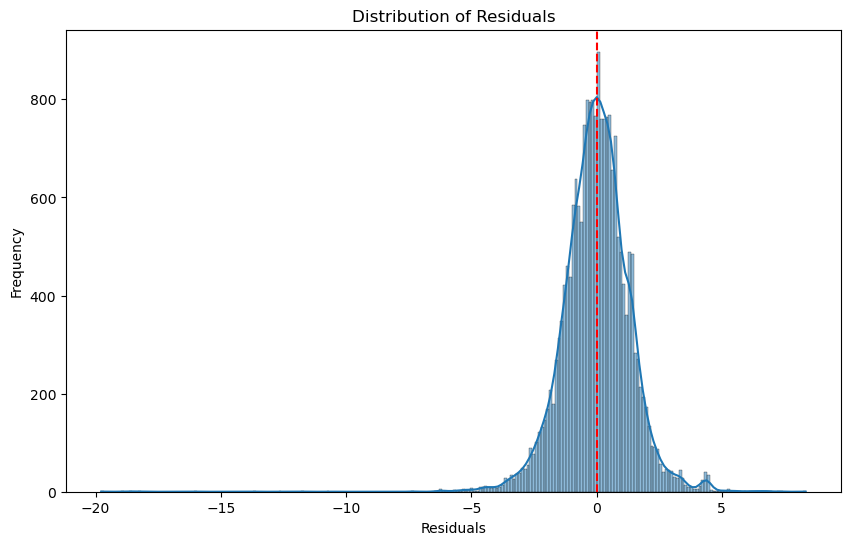

In [218]:
# Calculate residuals
residuals = y - y_pred

# Plot the distribution of residuals using a histogram and KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


#### Key Takeaways:
* Model Fit: The residuals are mostly centered around zero, indicating that the model has generally good fit without systematic bias
* Non-Normality: The right skewness suggests that the model may not fully capture all aspects of the data's behavior. This could be due to non-linear relationships or missing predictors that influence our label

Overall, the residual plot shows that the model's predictions are mostly unbiased, as errors are centered around zero. However, there is some skewness, which suggests that the model may miss certain patterns in the data, especially for bridges with unusual conditions. This could be explored further with additional predictors or different model types in future analyses.

#### Task 3: Regression Coefficient Analysis

**The multivariate linear regression equation for predicting Current Condition based on our five predictors is as follows:**


Current Condition = β0 + β1 * Age + β2 * Average Use + β3 * Percent Trucks 
                    + β4 * Material (Steel) + β5 * Material (Other Materials) 
                    + β6 * Design (Slab) + β7 * Design (Other Design) + ε
Where:

* β0 is the intercept.
* β1, β2, and β3 are the coefficients for Age, Average Use, and Percent Trucks, respectively.
* β4 and β5 are the coefficients for the Material categories:
* β4 represents the effect of Steel compared to the baseline (Concrete).
* β5 represents the effect of Other Materials compared to the baseline (Concrete).
* β6 and β7 are the coefficients for the Design categories:
* β6 represents the effect of Slab compared to the baseline (Beam).
* β7 represents the effect of Other Design compared to the baseline (Beam).
* ε is the error term, capturing variability in Current Condition not explained by the model.

The sign of each coefficient (whether it’s positive or negative) tells us the direction of the relationship between the predictor and the target variable:

* Positive Coefficient: If a coefficient is positive, it means that as the predictor variable increases, the target variable (Current Condition) also tends to increase, all else being equal
* Negative Coefficient: If a coefficient is negative, it indicates that as the predictor variable increases, the target variable tends to decrease, all else being equal

The magnitude of each coefficient reflects the strength of the relationship between the predictor and the target variable. In other words, it shows how much of an impact a one-unit change in the predictor variable has on the target variable:

* Larger Magnitude: A larger absolute value (magnitude) of a coefficient means that the predictor variable has a stronger impact on the target variable
* Smaller Magnitude: A smaller absolute value of a coefficient indicates that the predictor variable has a weaker impact on the target variable

In [219]:
import pandas as pd

# Get the coefficients from the model
coefficients = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': model.coef_
})

# Sort by the absolute value of the coefficient to see the most influential predictors
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)
print(coefficients)


                  Predictor   Coefficient  Absolute Coefficient
4  Material_Other Materials -2.734525e+00          2.734525e+00
3            Material_Steel -1.733077e+00          1.733077e+00
5       Design_Other Design  3.713502e-01          3.713502e-01
6               Design_Slab  1.679721e-01          1.679721e-01
0                       Age -6.522708e-02          6.522708e-02
2            Percent Trucks -3.404764e-03          3.404764e-03
1               Average Use -6.111980e-07          6.111980e-07


#### Task 4: Interpreting Each Predictor’s Influence
**Material (Other Materials):**

* Coefficient: -2.734525
* Range: Categorical, binary (0 or 1).
* Interpretation: This is the most influential predictor, with a negative coefficient. Bridges made of materials categorised as "Other Materials" tend to have significantly lower condition scores compared to the baseline material, "Concrete". 
* This suggests that "Other Materials" are associated with poorer bridge conditions.

**Material (Steel):**

* Coefficient: -1.733077
* Range: Categorical, binary (0 or 1).
* Interpretation: Similarly, bridges made of Steel have lower condition scores than those made of Concrete. This effect, while smaller than "Other Materials," is still notable, and as a binary variable, this influence is straightforward.

**Design (Other Design):**

* Coefficient: 0.371350
* Range: Categorical, binary (0 or 1).
* Interpretation: Bridges with "Other Design" types have slightly higher condition scores than the baseline "Beam" design. The effect size is smaller, but again, being binary, the impact is a straightforward 0.37 increase when this design type is used.

**Design (Slab):**

* Coefficient: 0.167972
* Range: Categorical, binary (0 or 1).
* Interpretation: Similar to "Other Design," having a Slab design contributes a 0.17-point increase in condition score compared to Beam design.

**Age:**

* Coefficient: -0.065227
* Range from new bridges to old bridges over 100 years old
* Although the coefficient is relatively small, age can span a large range (from young to very old bridges). For example, an increase of 50 years would result in a decrease in condition score of 50 x -0.065227 = -3.26135, which is quite substantial. This suggests that Age has a meaningful impact on condition over time

**Percent Trucks:**

* Coefficient: -0.003405
* Range: 0 to 100%.
*  The coefficient is small, but because Percent Trucks can range widely, it can still have a cumulative effect. For example, a 20% increase in truck traffic would reduce the condition score by 20 x -0.003405 = -0.0681, which is pretty minor. Therefore as expected the truck traffic does not have as big of an impact as other factors

**Average Use:**

* Coefficient: -6.1198e-07 (essentially zero)
* Range: Large, with values up to hundreds of thousands.
* Interpretation: Even though this coefficient is nearly zero, the large range of Average Use (average daily traffic) means it could still exert a small influence. For instance, an increase of 100,000 in daily traffic would lower the score by 100,000 x -6.1198e-07 = -0.0612. Therefore, similarly to percent trucks, the traffic volume alone doesn't meaningfuly impact bridge condition

### Task 5: Conclusions and Suggestions for Further Analysis

#### 1) Can the proposed variables predict the condition of the bridge accurately, and to what extent?

* Our analysis, using a multivariate linear regression model, shows that the proposed variables — Age, Average Use, Percent Trucks, Material, and Design—provide a reasonable ability to predict bridge condition. 
* The R² score of the model indicates that 46.12% of the variance in bridge condition is explained by these variables. 
* This means that the model captures moderate predictive power, which is suitable for making broad assessments about bridge conditions based on these factors.

* The RMSE of approximately 1.35 suggests that, on average, the model’s predictions deviate from the actual condition score by about 1.35 points. 
* This level of error is not critical in the context of the total range of bridge condition scores, which spans from 0 to 27. 
* If bridge conditions require very precise assessments for decision-making, this model might need further refinement. 
* However, if general trends are sufficient, this level of accuracy could be acceptable.

#### 2) Which of the proposed variables has more influence on the condition of the bridge?

* Material (particularly "Other Materials" and "Steel") is the most influential predictor. Bridges made from these materials tend to have significantly lower condition scores compared to those made of Concrete. This suggests that material choice is a critical factor in bridge durability.

* Age also has a notable impact; older bridges tend to be in worse condition. This aligns with expectations, as aging generally leads to structural deterioration.
* Design types such as "Other Design" and "Slab" contribute positively to the condition score relative to the baseline design type (Beam). However, the effect size is smaller than for Material and Age.

* Percent Trucks and Average Use have smaller coefficients, indicating a relatively minor influence on bridge condition. This may be due to maintenance efforts that offset the effects of daily traffic volume, or that percent truck traffic exerts only limited additional wear.

Overall, **Material** and **Age** emerge as the primary factors influencing bridge condition, which may guide future decisions on material choice and maintenance prioritization.

**Suggestions for Further Analysis**:

* Investigate Non-Linear Models: If more precise predictions are required, non-linear regression models or machine learning algorithms could be explored to capture complex relationships that a linear model may not fully capture.



* Incorporate Additional Predictors: Other potentially impactful variables, such as environmental factors (such as exposure to coastal conditions or pollution levels), could improve the model's accuracy. These factors may have significant effects on bridge condition and could help in fine-tuning predictions.

* Examine Interaction Effects: Interaction terms, such as between Material and Percent Trucks, could reveal if certain combinations of predictors jointly affect bridge condition. For example, truck traffic may impact bridges with certain materials more significantly.

* Periodic Re-Evaluation: Given that infrastructure conditions evolve, periodic updates to the model using recent data will help keep the predictions relevant and ensure that factors impacting bridge condition are up to date.

